In [221]:
# 1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): 
# логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта

# 2. при обучении моделей обязательно использовать кроссвалидацию

# 3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score 
# (можно в виде таблицы, где строки - модели, а столбцы - метрики)

# 4. сделать выводы о том, какая модель справилась с задачей лучше других

# 5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve)
# больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого).
# p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

# Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). Допустим, у нас две модели:

# первая помечает 100 объектов как класс 1, но TP = 90
# вторая помечает 1000 объектов как класс 1, но TP такой же - 90
# Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

In [222]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, log_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [223]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [224]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=42)

In [225]:
# К полям:

# gender, cholesterol применим OHE-кодирование
# age, height, weight, ap_hi, ap_lo - standardScaler
# gluc, smoke, alco, active - оставим пока как есть


class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]



continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [226]:
# Функция отрисовки кривой roc_auc

def roc_auc_curve(y_test, y_score):
    
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()
    
    return

In [227]:
# объединим все наши трансформеры с помощью FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[ 0.09144178,  0.44594423,  0.05752649, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.46216539,  0.20194394, -0.84752919, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.5702846 , -1.01805752,  1.79801819, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.67238553,  0.56794437, -0.01209318, ...,  0.        ,
         0.        ,  1.        ],
       [-0.50009534,  0.32394408, -0.29057185, ...,  0.        ,
         0.        ,  0.        ],
       [-1.76136594,  1.54394554, -0.70828985, ...,  0.        ,
         0.        ,  1.        ]])

In [228]:
# Таблица с метриками
table_comp = pd.DataFrame({'Model': [], 
                           'Threshold': [],
                           'F-Score': [],
                           'Precision': [],
                           'Recall': [],
                           'ROC AUC': []})

### Модель LogisticRegression

In [229]:
# добавим классификатор и запустим кросс-валидацию
classifier_logreg = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

# запустим кросс-валидацию
cv_scores = cross_val_score(classifier_logreg, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

# обучим пайплайн на всем тренировочном датасете
classifier_logreg.fit(X_train, y_train)
y_score_logreg = classifier_logreg.predict_proba(X_test)[:, 1]

CV score is 0.7821358976691873+-0.009748562688833385


In [230]:
# Посчитаем precision/recall/f_score

def metrics(y_test, y_score, model_name, i):
    b=1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score) 
    if model_name == 'GradBoost':
        recall = [i+1e-15 for i in recall]
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    ix = np.argmax(fscore)

    table_comp.loc[i] = [model_name, thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, y_score)]

    return

In [231]:
metrics(y_test, y_score_logreg, 'LogReg', 0)

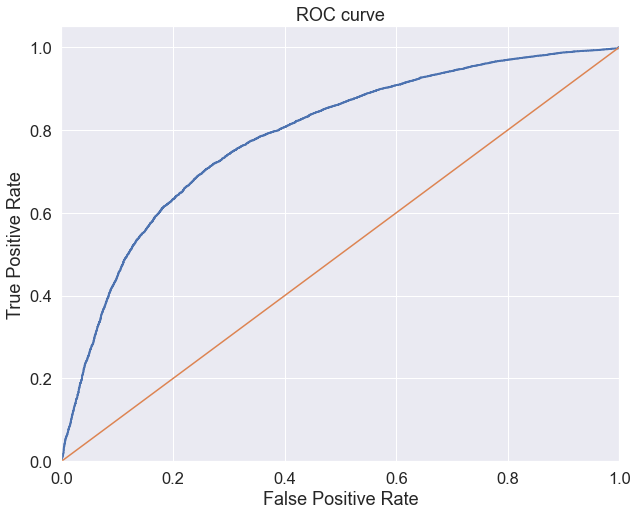

In [232]:
roc_auc_curve(y_test, y_score_logreg)

### Модель GradientBoostingClassifier

In [233]:
%%time
# добавим классификатор и запустим кросс-валидацию
classifier_gradboost = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=0.5,
                    max_depth=5, random_state=42)),
])

# запустим кросс-валидацию
cv_scores = cross_val_score(classifier_gradboost, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

# обучим пайплайн на всем тренировочном датасете
classifier_gradboost.fit(X_train, y_train)
y_score_gradboost = classifier_gradboost.predict_proba(X_test)[:, 1]

CV score is 0.7887869960345137+-0.007855263442181534
Wall time: 9min 1s


In [234]:
metrics(y_test, y_score_gradboost, 'GradBoost', 1)

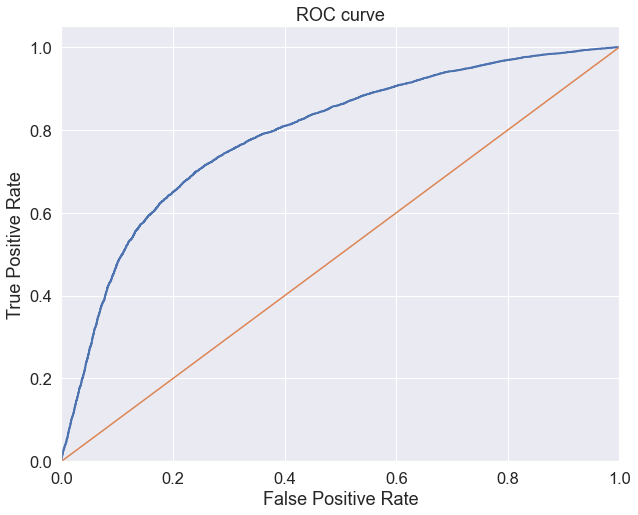

In [235]:
roc_auc_curve(y_test, y_score_gradboost)

### Модель RandomForestClassifier

In [236]:
%%time
# добавим классификатор и запустим кросс-валидацию
classifier_randforest = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=3, random_state=42)),
])

# запустим кросс-валидацию
cv_scores = cross_val_score(classifier_randforest, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

# обучим пайплайн на всем тренировочном датасете
classifier_randforest.fit(X_train, y_train)
y_score_randforest = classifier_randforest.predict_proba(X_test)[:, 1]

CV score is 0.7991681963496071+-0.008531940566953807
Wall time: 2min 22s


In [238]:
metrics(y_test, y_score_randforest, 'RandForest', 2)

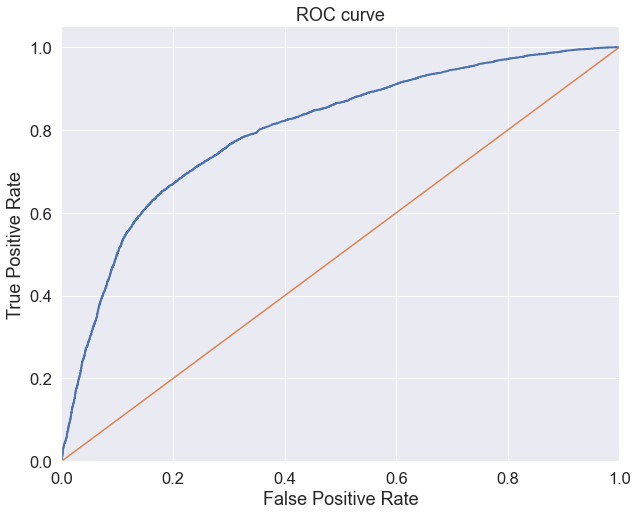

In [239]:
roc_auc_curve(y_test, y_score_randforest)

In [240]:
table_comp

,Model,Threshold,F-Score,Precision,Recall,ROC AUC
0,LogReg,0.397109,0.735426,0.655534,0.837494,0.785239
1,GradBoost,0.388215,0.736809,0.689764,0.790740,0.789535
2,RandForest,0.400645,0.745162,0.695952,0.801861,0.799413


**Вывод:** В целом все три модели показали близкие результаты, как по метрике fscore, так и по метрике ROC AUC. Однако алгоритм Случайного леса дал результаты чуть лучше, чем остальные модели. 

### Какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов?

**Ответ:** В случае дисбаланса классов для принятия решения больше подходит метрика precision_recall_curve, потому что метрика roc_auc_curve дает оптимистическую оценку модели. Причиной этого служит то, что результат roc_auc_curve основан на показателях TP и FP, в которых каждое измерение является строгим столбцовым соотношением, поэтому не зависит от распределения классов. Результат precision_recall_curve напротив, изменяется по мере изменения распределения классов.